<a href="https://colab.research.google.com/github/bgreat5/ML/blob/main/4.%20Demand%20Forecasting/Demand_Forecatsing_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Reading Data files*** 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_E1GspfA.csv to train_E1GspfA.csv


In [ ]:
import io
import pandas as pd
train = pd.read_csv(io.BytesIO(uploaded['train_E1GspfA.csv']))

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_6QvDdzb.csv to test_6QvDdzb.csv


In [ ]:
import io
import pandas as pd
test = pd.read_csv(io.BytesIO(uploaded['test_6QvDdzb.csv']))

### ***Data Preprocessing*** 

In [ ]:
train.head()
## Observation: Mising hour values

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [ ]:
train.date.min(),train.date.max()

('2018-08-18', '2021-02-28')

In [ ]:
from datetime import datetime
train['datetime'] = pd.to_datetime(train['date']+ ' ' +train['hour'].astype(str)+':00:00')

In [ ]:
train.datetime.min(),train.datetime.max()

(Timestamp('2018-08-18 09:00:00'), Timestamp('2021-02-28 23:00:00'))

In [ ]:
train_with_cont_time_values = pd.DataFrame(pd.date_range(start=train.datetime.min(),end=train.datetime.max(), freq='H')).rename(columns={0:'datetime'})
train_with_cont_time_values = train_with_cont_time_values.merge(train,on='datetime',how='left')
train_with_cont_time_values['hour'] = train_with_cont_time_values['datetime'].dt.hour
train_with_cont_time_values['date'] = train_with_cont_time_values['datetime'].dt.date
train_with_cont_time_values['day'] = train_with_cont_time_values['datetime'].dt.day
train_with_cont_time_values['month'] = train_with_cont_time_values['datetime'].dt.month
train_with_cont_time_values['year'] = train_with_cont_time_values['datetime'].dt.year
train_with_cont_time_values['day_of_week'] = train_with_cont_time_values['datetime'].dt.dayofweek
#train_with_cont_time_values = train_with_cont_time_values.drop(columns={'date','hour'})
train_with_cont_time_values = train_with_cont_time_values.fillna(0)

In [ ]:
train_with_cont_time_values.head()

,datetime,date,hour,demand,day,month,year,day_of_week
0,2018-08-18 09:00:00,2018-08-18,9,91.0,18,8,2018,5
1,2018-08-18 10:00:00,2018-08-18,10,21.0,18,8,2018,5
2,2018-08-18 11:00:00,2018-08-18,11,0.0,18,8,2018,5
3,2018-08-18 12:00:00,2018-08-18,12,0.0,18,8,2018,5
4,2018-08-18 13:00:00,2018-08-18,13,23.0,18,8,2018,5


In [ ]:
train_with_cont_time_values.shape

(22215, 4)

***Exploratory Data Analysis***

#### *ARIMA is non-seasonal and SARIMA has seasonal applicability. SARIMA has an extended applicability of ARIMA model: it includes seasonality of the data in it’s modelling and predictions.*

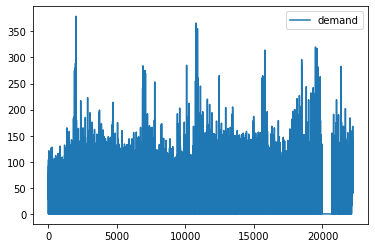

In [ ]:
from matplotlib import pyplot
train_with_cont_time_values[['date','demand']].plot()
pyplot.show()

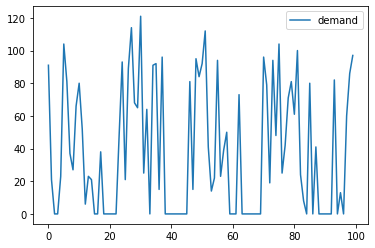

In [ ]:
from matplotlib import pyplot
train_with_cont_time_values[['date','demand']].head(100).plot()
pyplot.show()

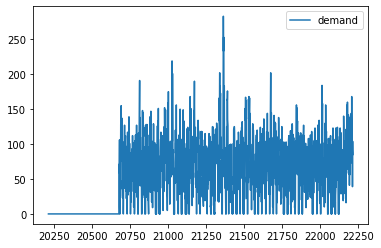

In [ ]:
from matplotlib import pyplot
train_with_cont_time_values[['date','demand']].tail(2000).plot()
pyplot.show()
## Observation: Maybe data is missing

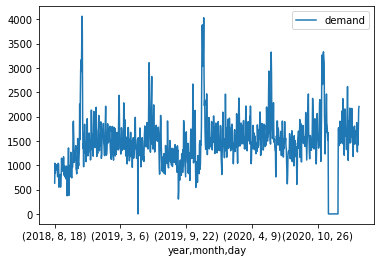

In [ ]:
## Checking for trend
from matplotlib import pyplot
train_with_cont_time_values.groupby(by=['year','month','day']).agg({'demand':'sum'}).plot()
pyplot.show()

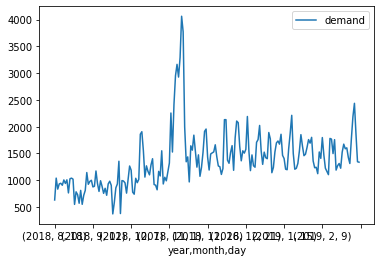

In [ ]:
from matplotlib import pyplot
train_with_cont_time_values.groupby(by=['year','month','day']).agg({'demand':'sum'}).head(200).plot()
pyplot.show()

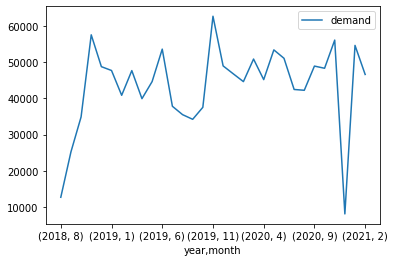

In [ ]:
#import matplotlib.pyplot as plt
from matplotlib import pyplot
train_with_cont_time_values.groupby(by=['year','month']).agg({'demand':'sum'}).plot()
pyplot.show()
## Observation: We can see data is following seasonality.

In [ ]:
## Checking if Data is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(train_with_cont_time_values['demand'])
#Ho: It is non-stationary
#H1: It is stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
      print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(train_with_cont_time_values['demand'])

ADF Test Statistic : -9.680280457539721
p-value : 1.2098065877330828e-16
#Lags Used : 47
Number of Observations : 22167
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:
## Checking the seasonal differnce and first difference

*Seasonality in a time series is a regular pattern of changes that repeats over S time periods, where S defines the number of time periods until the pattern repeats again.*

*Seasonal differencing is defined as a difference between a value and a value with lag that is a multiple of S.*

***Non-seasonal differencing*** *If trend is present in the data, we may also need non-seasonal differencing. Often (not always) a first difference (non-seasonal) will “detrend” the data.*

In [ ]:
train_with_cont_time_values['Demand First Difference'] = train_with_cont_time_values['demand'] - train_with_cont_time_values['demand'].shift(1)
train_with_cont_time_values['Seasonal First Difference'] = train_with_cont_time_values['demand'] - train_with_cont_time_values['demand'].shift(24)

In [ ]:
train_with_cont_time_values.head(5)

,datetime,date,hour,demand,day,month,year,day_of_week,Demand First Difference,Seasonal First Difference
0,2018-08-18 09:00:00,2018-08-18,9,91.0,18,8,2018,5,NaN,NaN
1,2018-08-18 10:00:00,2018-08-18,10,21.0,18,8,2018,5,-70.0,NaN
2,2018-08-18 11:00:00,2018-08-18,11,0.0,18,8,2018,5,-21.0,NaN
3,2018-08-18 12:00:00,2018-08-18,12,0.0,18,8,2018,5,0.0,NaN
4,2018-08-18 13:00:00,2018-08-18,13,23.0,18,8,2018,5,23.0,NaN


In [ ]:
# Again testing if data is stationary
adfuller_test(train_with_cont_time_values['Seasonal First Difference'].dropna())

ADF Test Statistic : -30.612729191074273
p-value : 0.0
#Lags Used : 47
Number of Observations : 22143
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


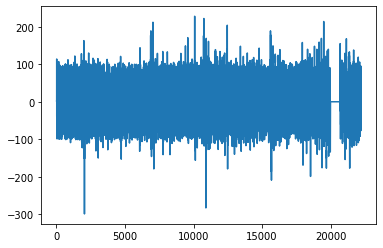

In [ ]:
train_with_cont_time_values['Seasonal First Difference'].plot()

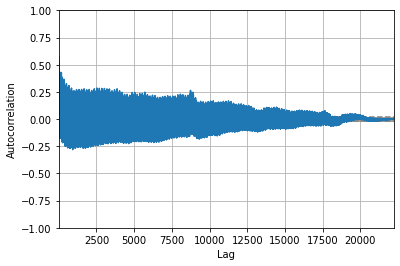

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train_with_cont_time_values['demand'])
pyplot.show()

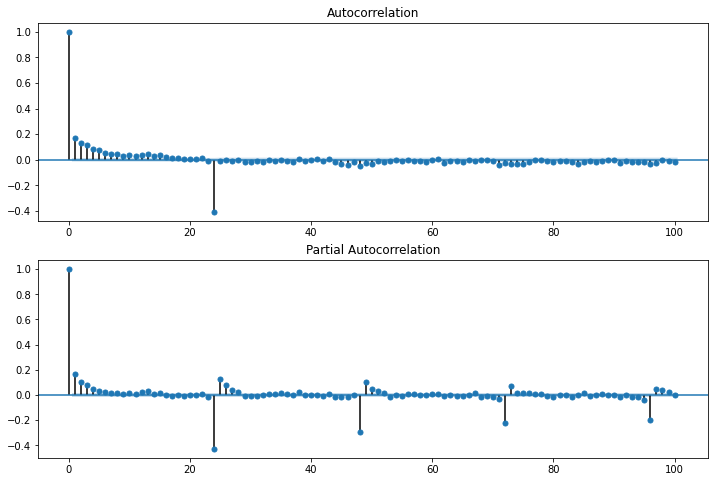

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_with_cont_time_values['Seasonal First Difference'].dropna(),lags=100,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_with_cont_time_values['Seasonal First Difference'].dropna(),lags=100,ax=ax2)

In [ ]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train_with_cont_time_values['demand'],order=(24,1,2))
model_fit=model.fit()
model_fit.summary()

KeyboardInterrupt: ignored

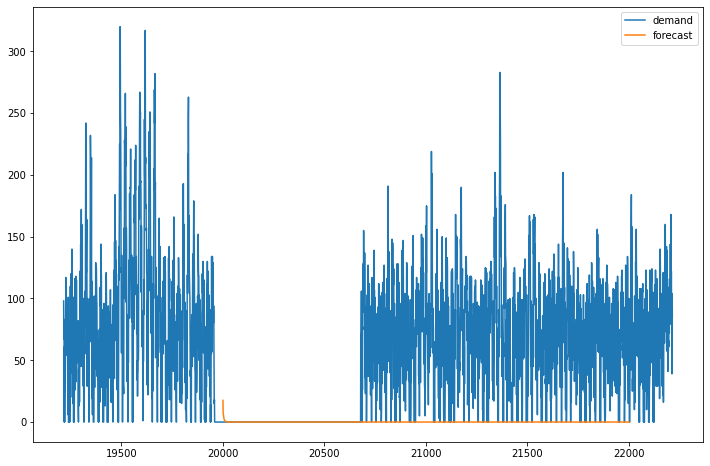

In [ ]:
train_with_cont_time_values['forecast']=model_fit.predict(start=20000,end=22000,dynamic=True)
train_with_cont_time_values[['demand','forecast']].tail(3000).plot(figsize=(12,8))

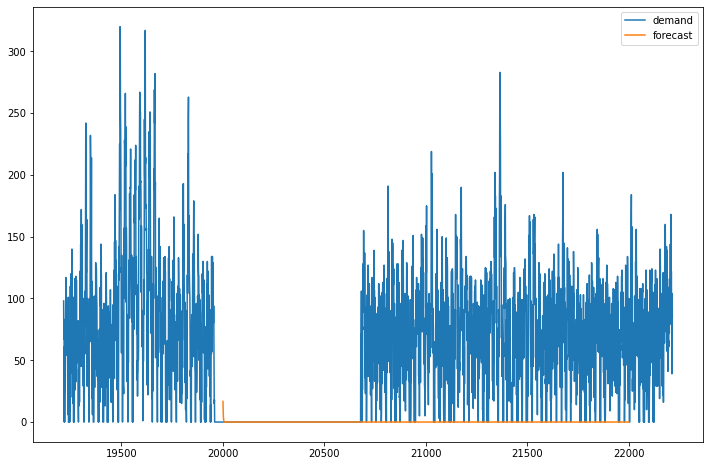

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(train_with_cont_time_values['demand'],order=(1, 1, 1),seasonal_order=(1,1,1,24))
results=model.fit()
train_with_cont_time_values['forecast']=model_fit.predict(start=20000,end=22000,dynamic=True)
train_with_cont_time_values[['demand','forecast']].tail(3000).plot(figsize=(12,8))